In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, constants
from astropy.time import Time

import hera_sim
import uvtools
from hera_sim import Simulator
from pyuvdata import UVData

In [2]:
# Set some of the default parameters for hera_sim to those
# appropriate for the H1C observing season
hera_sim.defaults.set("h1c")

In [3]:
# Use the Simulator to easily set up some mock data
sim_params = dict(
    Ntimes=100,
    start_time=2456658.5,  # 1 Jan 2014 in Julian Date
    integration_time=10.73,  # seconds
    Nfreqs=200,
    start_freq=100e6,   # Hz
    channel_width=100e6/1024,
    array_layout=hera_sim.antpos.hex_array(2, split_core=False, outriggers=0),
)
sim = Simulator(**sim_params)
uvd = sim.data  # The Simulator has a UVData object as its data attribute

The above cell sets up a ``Simulator`` object with 100 integrations of 10.73 seconds each, observing at frequencies from 100 MHz to about 120 MHz, with an array of 7 antennas configured into a hexagon. The next few cells investigate the different attributes of the underlying ``UVData`` object that the ``Simulator`` uses to store the data/metadata.

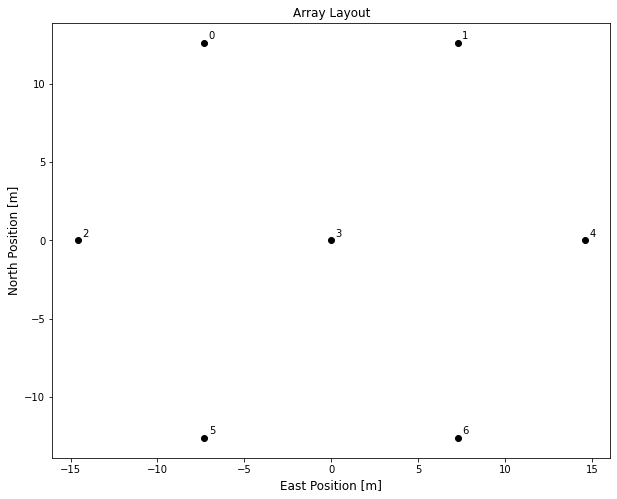

In [4]:
# Take a look at the array layout
fig = sim.plot_array()

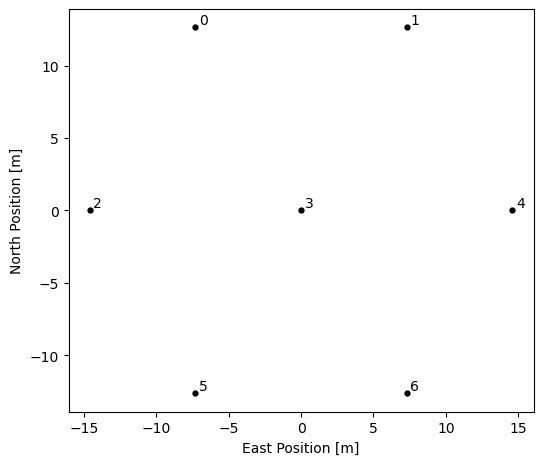

In [5]:
# Equivalent code for producing the above plot using a UVData object
pos, ants = uvd.get_ENU_antpos()
dx = 0.25  # offset for labeling antennas
fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111)
for ant, (e, n, u) in zip(ants, pos):
    ax.plot(e, n, marker='o', ms=3.5, color='k')
    ax.text(e + dx, n + dx, ant)
ax.set_xlabel("East Position [m]")
ax.set_ylabel("North Position [m]")
ax.set_aspect("equal");

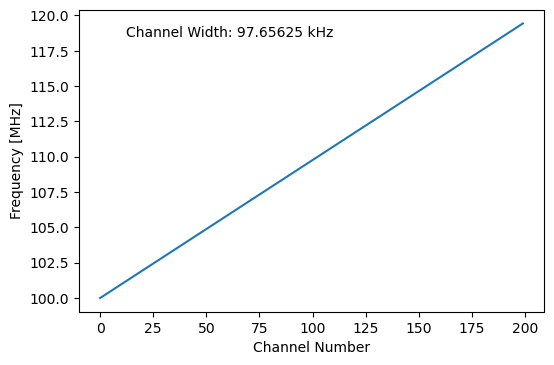

In [6]:
# Take a look at the frequency array
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.plot(uvd.freq_array.flatten() / 1e6)
ax.text(
    0.1,  # Close to the left side of the plot
    0.9,  # Close to the top of the plot
    f"Channel Width: {uvd.channel_width / 1e3} kHz",
    transform=ax.transAxes,  # Use normalized coordinates for placing text
    horizontalalignment="left",
    verticalalignment="bottom",
)
ax.set_xlabel("Channel Number")
ax.set_ylabel("Frequency [MHz]");

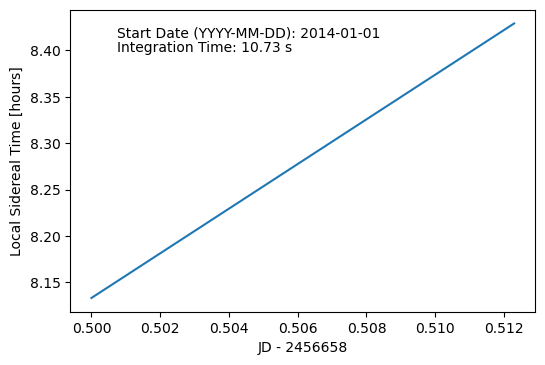

In [7]:
# Take a look at the timing information
times_jd, inds = np.unique(uvd.time_array, return_index=True)
start_time = times_jd[0]
start_date = Time(start_time, format="jd").to_datetime()
year = start_date.year
month = start_date.month
day = start_date.day
lsts = uvd.lst_array[inds]
lsts_hr = lsts * units.day.to("hr") * units.rad.to("cycle")
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.plot(times_jd - np.floor(start_time), lsts_hr)
ax.set_xlabel(f"JD - {int(np.floor(start_time))}")
ax.set_ylabel("Local Sidereal Time [hours]")
ax.text(
    0.1,
    0.9,
    f"Start Date (YYYY-MM-DD): {year}-{month:02d}-{day:02d}",
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="bottom",
)
ax.text(
    0.1,
    0.85,
    f"Integration Time: {uvd.integration_time[0]:.2f} s",
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="bottom",
);

You'll notice in the previous cell that the times were extracted using ``np.unique``. This is because the time and LST arrays actually have multiple copies of the same times, which is a result of the way data is actually stored in a ``UVData`` object. ``UVData`` objects combine the baseline and time axes to form a baseline-time axis, and then an order on that axis is defined so that various ``UVData`` methods know how to slice along it in order to retrieve data. Let's see how this works for the default case:

In [8]:
# By default, each time is repeated for as many baselines as there are in the data
np.all(uvd.time_array[0] == uvd.time_array[:uvd.Nbls])

True

In [9]:
# This is an alternate way of showing that:
np.all(times_jd == uvd.time_array[::uvd.Nbls])

True

In [10]:
# Just to show that this is the case for the default baseline-time ordering
uvd.blt_order is None

True

In [11]:
# If you want to change the ordering so that the time axis is sorted
# to cycle through the times for each baseline, then you can do this:
uvd.reorder_blts("baseline", "time")

In [12]:
# So now the time axis is segmented into Nbls chunks of length Ntimes
np.all(times_jd == uvd.time_array[:uvd.Ntimes])

True

In [13]:
np.all(uvd.time_array[0] == uvd.time_array[::uvd.Ntimes])

True

Now let's experiment a bit with the data-like attributes.

In [14]:
# Actually mock up some data, but let's cover more times
new_params = sim_params.copy()
new_params.update(dict(Ntimes=200, integration_time=30))
sim = Simulator(**new_params)
uvd = sim.data
sim.add("diffuse_foreground", seed="redundant")

In [15]:
# First: the shape of the data-like arrays
uvd.data_array.shape == (uvd.Nblts, 1, uvd.Nfreqs, uvd.Npols)

True

In [16]:
# If we want to retrieve data for a particular baseline/polarization,
# then we just do this:
vis = uvd.get_data(1, 5, "xx")  # Baseline (1, 5), polarization "xx"

In [17]:
# This gives us a "waterfall", with time on the 0-th axis
# and frequency on the 1-th axis:
vis.shape == (uvd.Ntimes, uvd.Nfreqs)

True

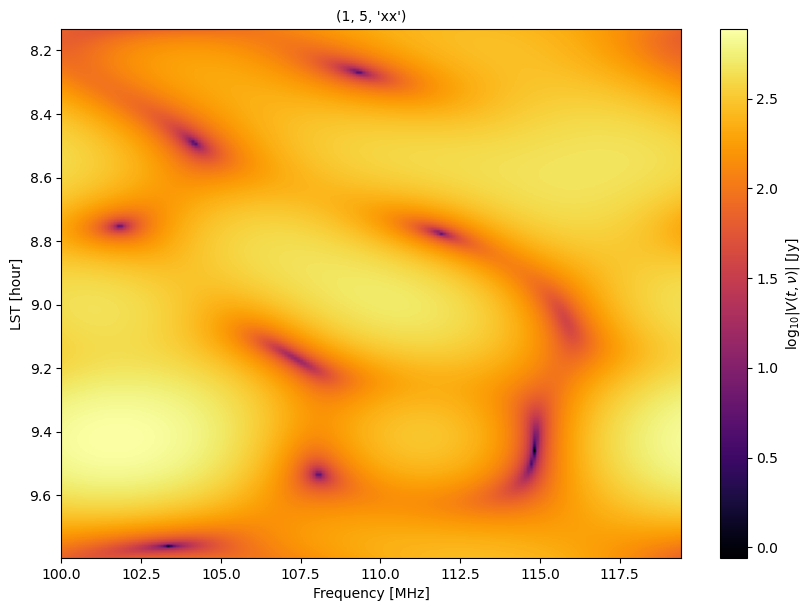

In [18]:
# Here's what it looks like:
fig = uvtools.plot.labeled_waterfall(uvd, antpairpol=(1, 5, "xx"))